### This notebook is for additional carbonate chemistry evaluations, including Puget Sound. 
#### Observation data were obtained from: /data/rbeutel/obs/PNW_obs_compiled.csv
#### Observation-model matches are from: OA_PugetSound_CarbonateChemModelvsObsMatches20152018_v202111.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc

fs=14
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [2]:
## Bringing in observation-model matches
data = pd.read_csv('PugetSound_CarbonateChemModelvsObsMatches_2007to2024_Eval202111.csv', index_col=0,header=0)

In [3]:
data.keys()

Index(['Unnamed: 0.1', 'dtUTC', 'Lon', 'Lat', 'Z', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'Co (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_nitrate', 'mod_ammonium', 'mod_silicon',
       'mod_diatoms', 'mod_flagellates', 'k'],
      dtype='object')

In [4]:
data['DO (umol kg-1)']

0         305.970107
1         265.686342
2         228.856871
3         207.530559
4         190.418600
             ...    
144307    211.152339
144308    211.001526
144309    210.420764
144310    208.752866
144311    208.208073
Name: DO (umol kg-1), Length: 144312, dtype: float64

In [5]:
DO_datapoints=data['DO (umol kg-1)'].isna().sum(axis=0)
print(DO_datapoints)

10809


In [6]:
DIC_datapoints=data['DIC (uM)'].isna().sum(axis=0)
print(DIC_datapoints)

144239


(0.0, 700.0)

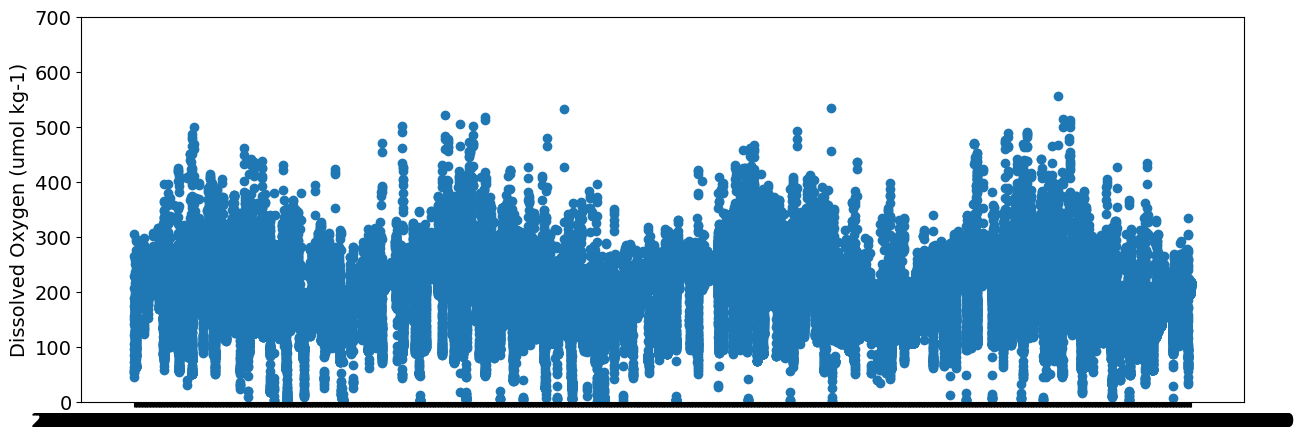

In [7]:
fig, ax = plt.subplots(1,figsize = (15,5))
ax.scatter(data['dtUTC'],data['DO (umol kg-1)'])
ax.set_ylabel('Dissolved Oxygen (umol kg-1)')
ax.set_ylim(0,700)
#plt.xticks(rotation=45)

(0.0, 3000.0)

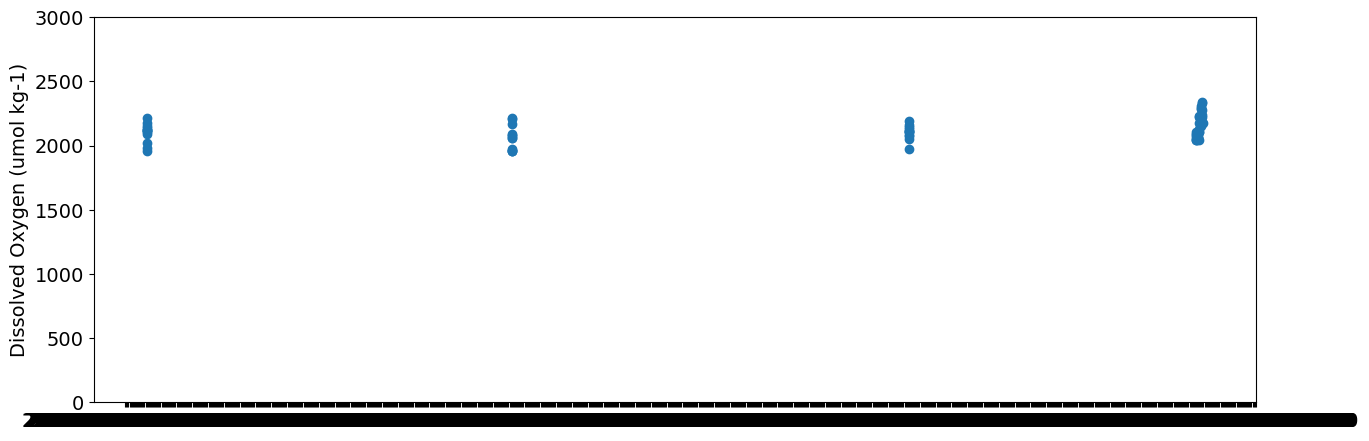

In [8]:
fig, ax = plt.subplots(1,figsize = (15,5))
ax.scatter(data['dtUTC'],data['DIC (uM)'])
ax.set_ylabel('Dissolved Oxygen (umol kg-1)')
ax.set_ylim(0,3000)
#plt.xticks(rotation=45)

In [9]:
## Create a column for subregions within the Salish Sea
data['broadregions']=np.nan

In [10]:
## Select data for only within the Central SoG
data.loc[((data['Lat'] >= 49.1)& (data['Lat'] < 49.5) & (data['Lon'] <= -123.1) & (data['Lon'] > -124)),['broadregions']]='Central SoG'

In [11]:
## Select data for only within the Juan de Fuca Strait
data.loc[((data['Lat'] >= 48.2) & (data['Lat'] < 48.5) & (data['Lon'] <= -123.5) & (data['Lon'] > -124.5)),['broadregions']]='JdF'

In [12]:
## Select data for only within Puget Sound
data.loc[((data['Lat'] <= 48) & (data['Lon'] <= -122) & (data['Lon'] > -123.5)),['broadregions']]='Puget Sound'

In [13]:
data.broadregions.unique()

array(['Puget Sound', nan, 'Central SoG', 'JdF'], dtype=object)

In [14]:
#data=data.dropna(subset=['broadregions']) ## Remove NaN values until I figure out how to classify all subregions

In [15]:
data.broadregions.unique()

array(['Puget Sound', nan, 'Central SoG', 'JdF'], dtype=object)

In [16]:
## Check Obs values

print(data['DIC (uM)'].min())
print(data['DIC (uM)'].max())
print(data['DIC (uM)'].mean())

1955.4234270651232
2336.1470329163385
2120.84755451395


In [17]:
## Check Model values

print(data['mod_dissolved_inorganic_carbon'].min())
print(data['mod_dissolved_inorganic_carbon'].max())
print(data['mod_dissolved_inorganic_carbon'].mean())

0.0
2324.0693359375
2049.151465791556


In [18]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [19]:
data

,Unnamed: 0.1,dtUTC,Lon,Lat,Z,pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,mod_dissolved_inorganic_carbon,mod_total_alkalinity,mod_dissolved_oxygen,mod_nitrate,mod_ammonium,mod_silicon,mod_diatoms,mod_flagellates,k,broadregions
0,2509628,2015-01-13 16:00:00,-122.93,47.40,1.0,1.000,8.258499,17.934871,305.970107,NaN,...,1131.471313,1143.802612,225.093613,11.570600,2.689703,90.821449,0.212184,0.151519,0,Puget Sound
1,2509629,2015-01-13 16:00:00,-122.93,47.40,2.0,1.875,8.968248,21.869836,265.686342,16.610001,...,1298.652222,1325.917114,245.861694,13.469675,2.180993,80.764801,0.293044,0.198564,1,Puget Sound
2,2509630,2015-01-13 16:00:00,-122.93,47.40,3.0,3.000,9.339697,23.934276,228.856871,NaN,...,1648.182495,1701.278687,222.139282,17.653564,1.651437,61.952038,0.445647,0.175285,2,Puget Sound
3,2509631,2015-01-13 16:00:00,-122.93,47.40,4.0,4.000,9.543563,25.033449,207.530559,NaN,...,1865.329590,1929.129272,185.729034,20.721514,1.434744,52.166523,0.477504,0.165450,3,Puget Sound
4,2509632,2015-01-13 16:00:00,-122.93,47.40,5.0,5.000,9.748995,25.943044,190.418600,NaN,...,1916.870361,1977.679932,163.702927,21.995152,1.376267,51.699417,0.446241,0.167756,4,Puget Sound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144307,3001681,2018-12-10 22:00:00,-122.84,47.26,44.0,44.000,10.529358,30.081431,211.152339,NaN,...,2012.052490,2110.113770,216.341461,19.753119,1.318764,39.711098,0.194880,0.127362,23,Puget Sound
144308,3001682,2018-12-10 22:00:00,-122.84,47.26,45.0,45.000,10.533557,30.083614,211.001526,NaN,...,2012.052490,2110.113770,216.341461,19.753119,1.318764,39.711098,0.194880,0.127362,23,Puget Sound
144309,3001683,2018-12-10 22:00:00,-122.84,47.26,46.0,46.000,10.544623,30.089280,210.420764,NaN,...,2012.052490,2110.113770,216.341461,19.753119,1.318764,39.711098,0.194880,0.127362,23,Puget Sound
144310,3001684,2018-12-10 22:00:00,-122.84,47.26,47.0,47.000,10.573155,30.103924,208.752866,NaN,...,2012.052490,2110.113770,216.341461,19.753119,1.318764,39.711098,0.194880,0.127362,23,Puget Sound


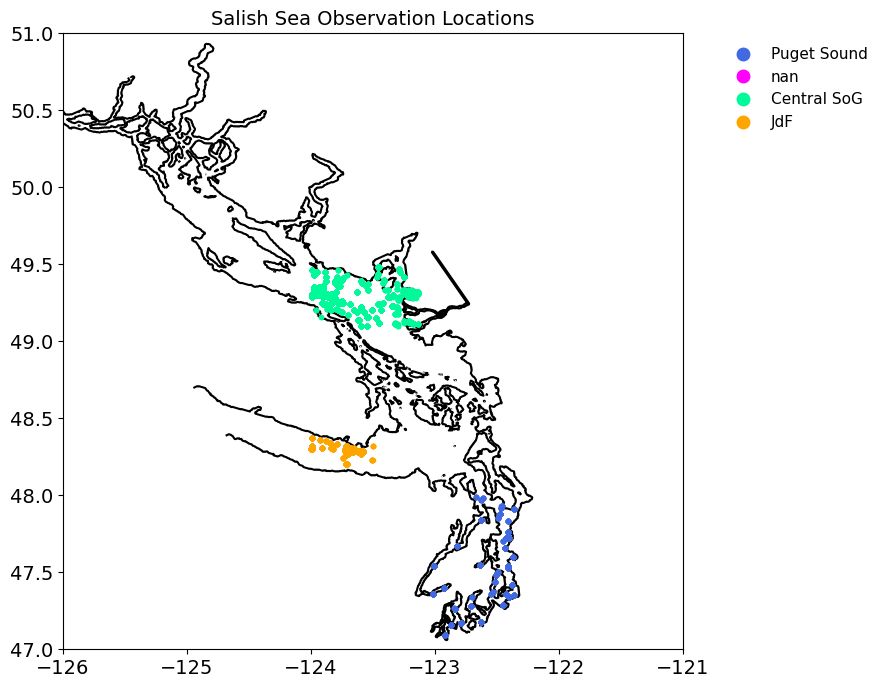

In [20]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('royalblue',
'fuchsia','mediumspringgreen',
'orange','green',

'black',
'darkviolet',
 'lightblue',

'firebrick','lime','darkgoldenrod','darkorange','deepskyblue','teal','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.broadregions.unique()):
    datreg[iregion] = data.loc[data.broadregions==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -121);
ax.set_title('Salish Sea Observation Locations');
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
#fig.savefig('SalishSeaObservationLocations.jpg',bbox_inches='tight')

In [21]:
def byRegion(ax,obsvar,modvar,lims):
    SS=[]
    for ind, iregion in enumerate(data.broadregions.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SS.append(SS0)
    l=ax.legend(handles=[ip[0][0] for ip in SS])
    ax.set_xlabel(' ')
    ax.set_ylabel('')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [22]:
data['broadregions']

0         Puget Sound
1         Puget Sound
2         Puget Sound
3         Puget Sound
4         Puget Sound
             ...     
144307    Puget Sound
144308    Puget Sound
144309    Puget Sound
144310    Puget Sound
144311    Puget Sound
Name: broadregions, Length: 144312, dtype: object

In [25]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [26]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [27]:
from matplotlib.colors import LogNorm

In [23]:
data['mod_chl'] = (data['mod_diatoms']+data['mod_flagellates'])*1.8

In [28]:
data['L10_Chl (mg m-3)']=logt(data['Chl (mg m-3)'])
data['L10_mod_chl']=logt(data['mod_chl'])

In [29]:
Puget=data.loc[data['broadregions']=='Puget Sound']
CentralSoG=data.loc[data['broadregions']=='Central SoG']
JdF=data.loc[data['broadregions']=='JdF']

In [30]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [31]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

Text(0, 0.5, 'Model Nitrate (mmol m-3)')

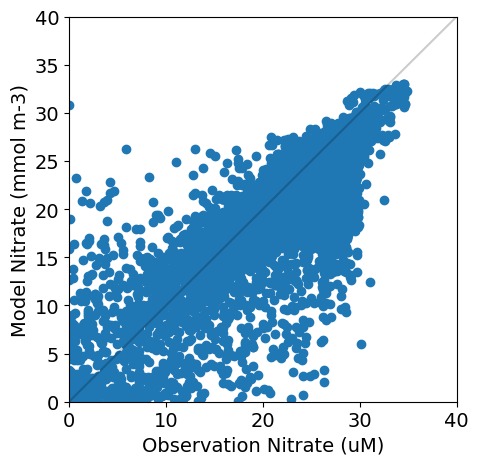

In [32]:
## Nitrate
fig, ax = plt.subplots(1,figsize = (5,5))
ax.scatter((data['NO3 (uM)']),(data['mod_nitrate']))
ax.set_ylim(0,40)
ax.set_xlim(0,40)
ax.plot((0,40),(0,40),'k-',alpha=.2)
ax.set_xlabel('Observation Nitrate (uM)')
ax.set_ylabel('Model Nitrate (mmol m-3)')

Text(0.5, 1.0, 'Puget Sound')

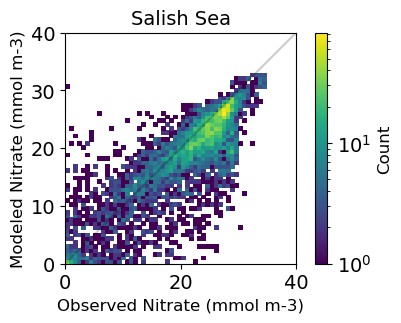

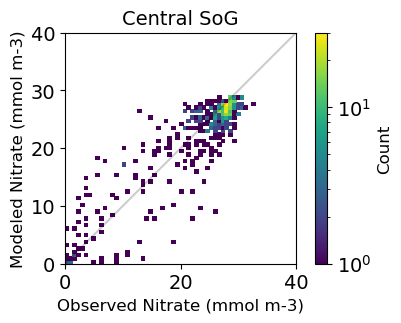

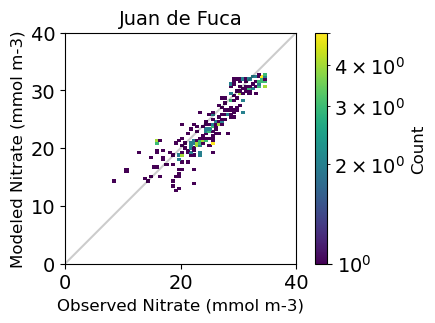

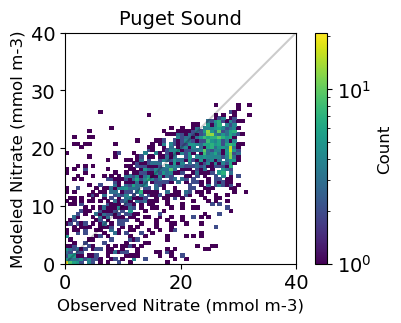

In [33]:
data=data
fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(data['NO3 (uM)']))&(~np.isnan(data['mod_nitrate']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['NO3 (uM)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_nitrate']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,40),(0,40),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_aspect(1)
ax.set_ylabel('Modeled Nitrate (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Nitrate (mmol m-3)',fontsize=12)
ax.set_title('Salish Sea')


fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(CentralSoG['NO3 (uM)']))&(~np.isnan(CentralSoG['mod_nitrate']))
counts, xedges, yedges, m1=ax.hist2d((CentralSoG.loc[ii,['NO3 (uM)']].values.flatten()+.001),
                                      (CentralSoG.loc[ii,['mod_nitrate']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,40),(0,40),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_aspect(1)
ax.set_ylabel('Modeled Nitrate (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Nitrate (mmol m-3)',fontsize=12)
ax.set_title('Central SoG')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(JdF['NO3 (uM)']))&(~np.isnan(JdF['mod_nitrate']))
counts, xedges, yedges, m1=ax.hist2d((JdF.loc[ii,['NO3 (uM)']].values.flatten()+.001),
                                      (JdF.loc[ii,['mod_nitrate']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,40),(0,40),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_aspect(1)
ax.set_ylabel('Modeled Nitrate (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Nitrate (mmol m-3)',fontsize=12)
ax.set_title('Juan de Fuca')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(Puget['NO3 (uM)']))&(~np.isnan(Puget['mod_nitrate']))
counts, xedges, yedges, m1=ax.hist2d((Puget.loc[ii,['NO3 (uM)']].values.flatten()+.001),
                                      (Puget.loc[ii,['mod_nitrate']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,40),(0,40),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,40)
ax.set_ylim(0,40)
ax.set_aspect(1)
ax.set_ylabel('Modeled Nitrate (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Nitrate (mmol m-3)',fontsize=12)
ax.set_title('Puget Sound')



Text(0, 0.5, 'Model Ammonium (mmol m-3)')

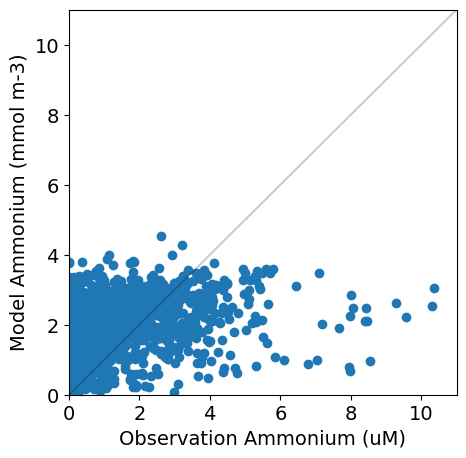

In [34]:
## Ammonium
fig, ax = plt.subplots(1,figsize = (5,5))
ax.scatter((data['NH4 (uM)']),(data['mod_ammonium']))
ax.set_ylim(0,11)
ax.set_xlim(0,11)
ax.plot((0,11),(0,11),'k-',alpha=.2)
ax.set_xlabel('Observation Ammonium (uM)')
ax.set_ylabel('Model Ammonium (mmol m-3)')

Text(0.5, 1.0, 'Salish Sea')

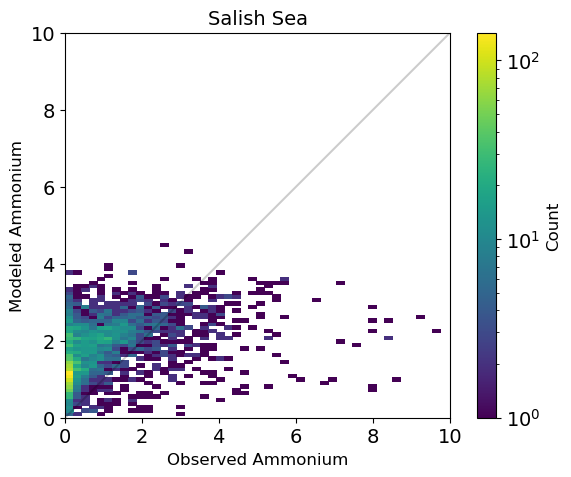

In [35]:
data=data
fig,ax=plt.subplots(1,1,figsize=(7,5))
ii=(~np.isnan(data['NH4 (uM)']))&(~np.isnan(data['mod_ammonium']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['NH4 (uM)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_ammonium']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,10),(0,10),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_aspect(1)
ax.set_ylabel('Modeled Ammonium',fontsize=12)
ax.set_xlabel('Observed Ammonium',fontsize=12)
ax.set_title('Salish Sea')



In [36]:
data['NH4 (uM)']

0          NaN
1         0.08
2          NaN
3          NaN
4          NaN
          ... 
144307     NaN
144308     NaN
144309     NaN
144310     NaN
144311    0.81
Name: NH4 (uM), Length: 144312, dtype: float64

In [37]:
data['SiO4 (uM)'].max()

159.22000122070312

Text(0, 0.5, 'Model Silicon (mmol m-3)')

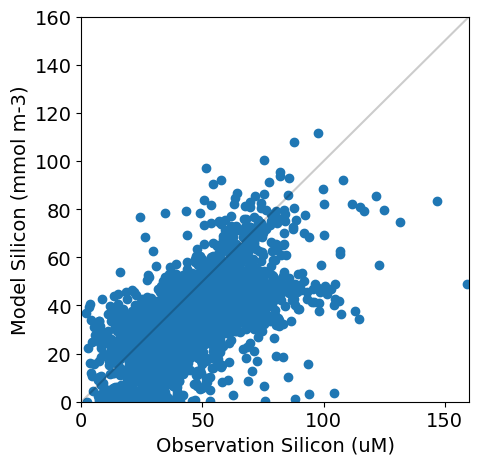

In [38]:
## Silicon
fig, ax = plt.subplots(1,figsize = (5,5))
ax.scatter((data['SiO4 (uM)']),(data['mod_silicon']))
ax.set_ylim(0,160)
ax.set_xlim(0,160)
ax.plot((0,160),(0,160),'k-',alpha=.2)
ax.set_xlabel('Observation Silicon (uM)')
ax.set_ylabel('Model Silicon (mmol m-3)')

Text(0.5, 1.0, 'Puget Sound')

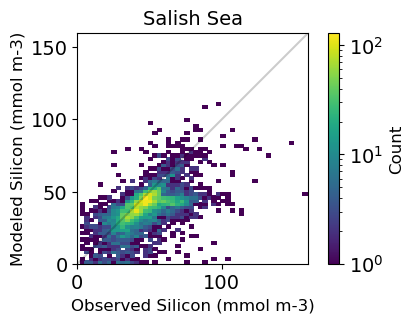

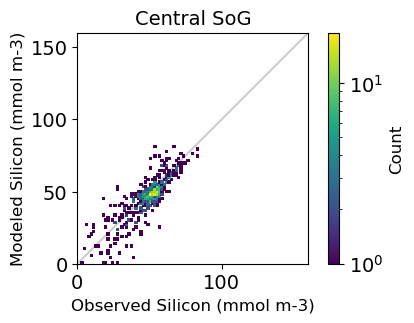

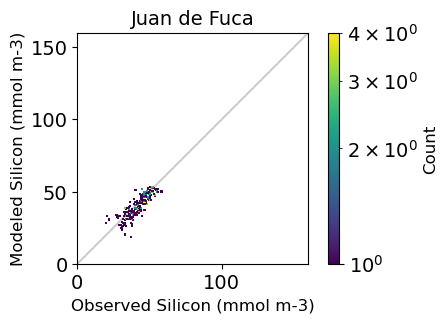

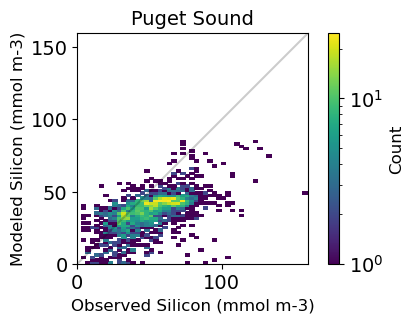

In [39]:
data=data
fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(data['SiO4 (uM)']))&(~np.isnan(data['mod_silicon']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['SiO4 (uM)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_silicon']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,160),(0,160),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,160)
ax.set_ylim(0,160)
ax.set_aspect(1)
ax.set_ylabel('Modeled Silicon (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Silicon (mmol m-3)',fontsize=12)
ax.set_title('Salish Sea')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(CentralSoG['SiO4 (uM)']))&(~np.isnan(CentralSoG['mod_silicon']))
counts, xedges, yedges, m1=ax.hist2d((CentralSoG.loc[ii,['SiO4 (uM)']].values.flatten()+.001),
                                      (CentralSoG.loc[ii,['mod_silicon']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,160),(0,160),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,160)
ax.set_ylim(0,160)
ax.set_aspect(1)
ax.set_ylabel('Modeled Silicon (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Silicon (mmol m-3)',fontsize=12)
ax.set_title('Central SoG')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(JdF['SiO4 (uM)']))&(~np.isnan(JdF['mod_silicon']))
counts, xedges, yedges, m1=ax.hist2d((JdF.loc[ii,['SiO4 (uM)']].values.flatten()+.001),
                                      (JdF.loc[ii,['mod_silicon']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,160),(0,160),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,160)
ax.set_ylim(0,160)
ax.set_aspect(1)
ax.set_ylabel('Modeled Silicon (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Silicon (mmol m-3)',fontsize=12)
ax.set_title('Juan de Fuca')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(Puget['SiO4 (uM)']))&(~np.isnan(Puget['mod_silicon']))
counts, xedges, yedges, m1=ax.hist2d((Puget.loc[ii,['SiO4 (uM)']].values.flatten()+.001),
                                      (Puget.loc[ii,['mod_silicon']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,160),(0,160),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,160)
ax.set_ylim(0,160)
ax.set_aspect(1)
ax.set_ylabel('Modeled Silicon (mmol m-3)',fontsize=12)
ax.set_xlabel('Observed Silicon (mmol m-3)',fontsize=12)
ax.set_title('Puget Sound')

Text(0, 0.5, 'Model Chl a (mg m-3)')

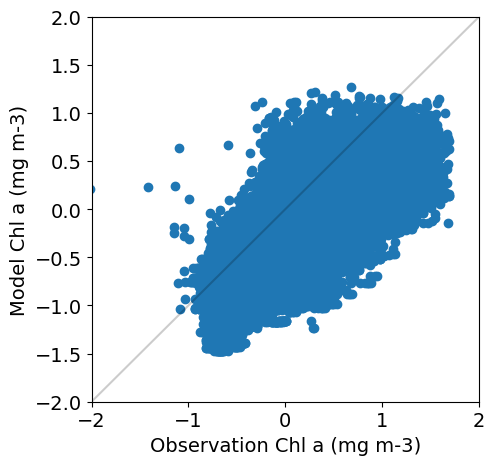

In [40]:
## Chl a
fig, ax = plt.subplots(1,figsize = (5,5))
ax.scatter((logt(data['Chl (mg m-3)'])),logt(data['mod_chl']))
ax.set_ylim(-2,2)
ax.set_xlim(-2,2)
ax.plot((-2,2),(-2,2),'k-',alpha=.2)
ax.set_xlabel('Observation Chl a (mg m-3)')
ax.set_ylabel('Model Chl a (mg m-3)')

Text(0.5, 1.0, 'Puget Sound')

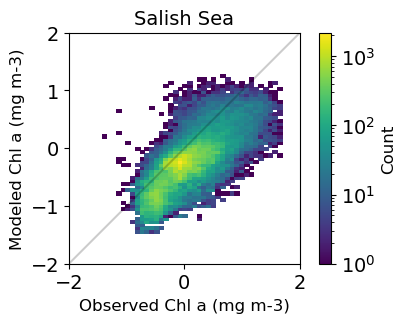

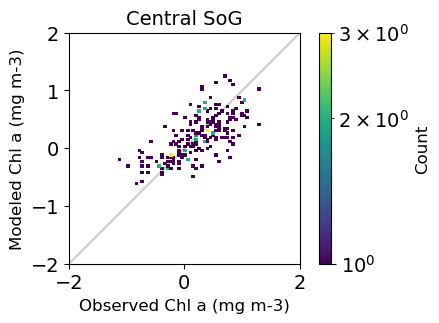

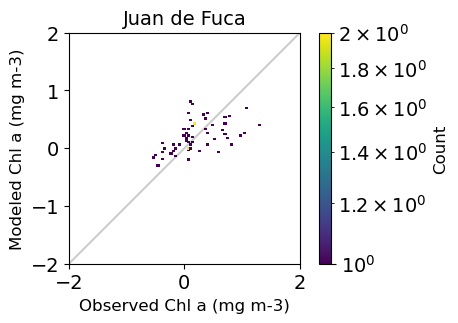

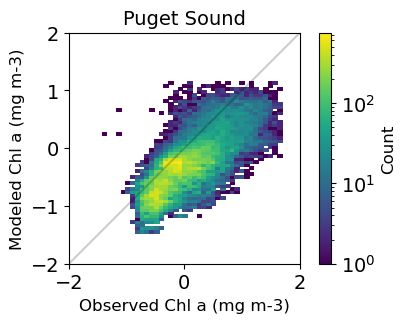

In [67]:
data=data
fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(data['L10_Chl (mg m-3)']))&(~np.isnan(data['L10_mod_chl']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['L10_Chl (mg m-3)']].values.flatten()+.001),
                                      (data.loc[ii,['L10_mod_chl']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2,2),(-2,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect(1)
ax.set_ylabel('Modeled Chl a (mg m-3)',fontsize=12)
ax.set_xlabel('Observed Chl a (mg m-3)',fontsize=12)
ax.set_title('Salish Sea')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(CentralSoG['L10_Chl (mg m-3)']))&(~np.isnan(CentralSoG['L10_mod_chl']))
counts, xedges, yedges, m1=ax.hist2d((CentralSoG.loc[ii,['L10_Chl (mg m-3)']].values.flatten()+.001),
                                      (CentralSoG.loc[ii,['L10_mod_chl']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2,2),(-2,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect(1)
ax.set_ylabel('Modeled Chl a (mg m-3)',fontsize=12)
ax.set_xlabel('Observed Chl a (mg m-3)',fontsize=12)
ax.set_title('Central SoG')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(JdF['L10_Chl (mg m-3)']))&(~np.isnan(JdF['L10_mod_chl']))
counts, xedges, yedges, m1=ax.hist2d((JdF.loc[ii,['L10_Chl (mg m-3)']].values.flatten()+.001),
                                      (JdF.loc[ii,['L10_mod_chl']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2,2),(-2,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect(1)
ax.set_ylabel('Modeled Chl a (mg m-3)',fontsize=12)
ax.set_xlabel('Observed Chl a (mg m-3)',fontsize=12)
ax.set_title('Juan de Fuca')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(Puget['L10_Chl (mg m-3)']))&(~np.isnan(Puget['L10_mod_chl']))
counts, xedges, yedges, m1=ax.hist2d((Puget.loc[ii,['L10_Chl (mg m-3)']].values.flatten()+.001),
                                      (Puget.loc[ii,['L10_mod_chl']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((-2,2),(-2,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect(1)
ax.set_ylabel('Modeled Chl a (mg m-3)',fontsize=12)
ax.set_xlabel('Observed Chl a (mg m-3)',fontsize=12)
ax.set_title('Puget Sound')

## Take a look at some evaluations for DIC, Total Alkalinity, Dissolved Oxygen:

Text(0.5, 1.0, 'Puget Sound')

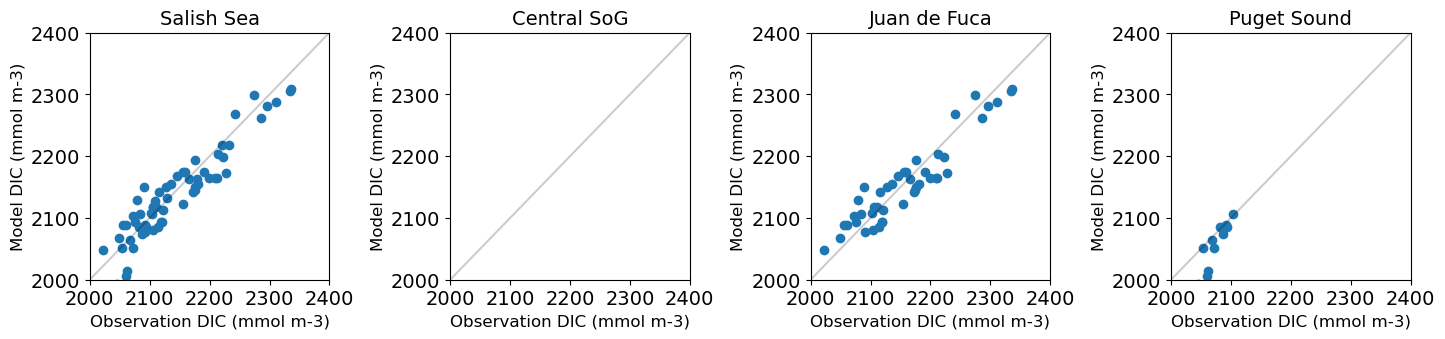

In [65]:
## DIC
fig, ax = plt.subplots(1,4,figsize = (15,4))
fig.tight_layout(pad=3)
ax[0].scatter((data['DIC (uM)']),(data['mod_dissolved_inorganic_carbon']))
ax[0].set_ylim(2000,2400)
ax[0].set_xlim(2000,2400)
ax[0].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[0].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[0].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[0].set_title('Salish Sea')


ax[1].scatter((CentralSoG['DIC (uM)']),(CentralSoG['mod_dissolved_inorganic_carbon']))
ax[1].set_ylim(2000,2400)
ax[1].set_xlim(2000,2400)
ax[1].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[1].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[1].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[1].set_title('Central SoG')

ax[2].scatter((JdF['DIC (uM)']),(JdF['mod_dissolved_inorganic_carbon']))
ax[2].set_ylim(2000,2400)
ax[2].set_xlim(2000,2400)
ax[2].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[2].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[2].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[2].set_title('Juan de Fuca')

ax[3].scatter((Puget['DIC (uM)']),(Puget['mod_dissolved_inorganic_carbon']))
ax[3].set_ylim(2000,2400)
ax[3].set_xlim(2000,2400)
ax[3].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[3].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[3].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[3].set_title('Puget Sound')



Text(0.5, 1.0, 'Puget Sound')

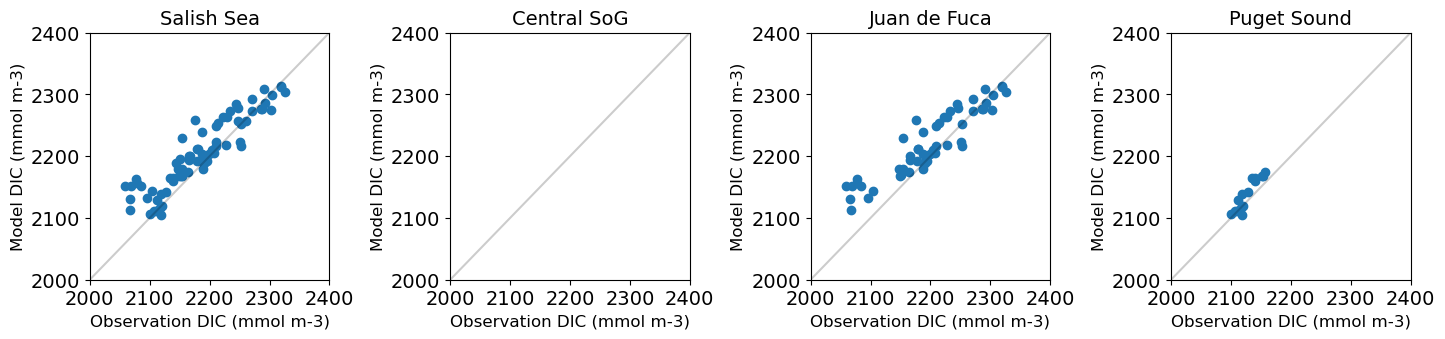

In [69]:
#Total Alkalinity

fig, ax = plt.subplots(1,4,figsize = (15,4))
fig.tight_layout(pad=3)
ax[0].scatter((data['TA (uM)']),(data['mod_total_alkalinity']))
ax[0].set_ylim(2000,2400)
ax[0].set_xlim(2000,2400)
ax[0].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[0].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[0].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[0].set_title('Salish Sea')


ax[1].scatter((CentralSoG['TA (uM)']),(CentralSoG['mod_total_alkalinity']))
ax[1].set_ylim(2000,2400)
ax[1].set_xlim(2000,2400)
ax[1].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[1].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[1].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[1].set_title('Central SoG')

ax[2].scatter((JdF['TA (uM)']),(JdF['mod_total_alkalinity']))
ax[2].set_ylim(2000,2400)
ax[2].set_xlim(2000,2400)
ax[2].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[2].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[2].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[2].set_title('Juan de Fuca')

ax[3].scatter((Puget['TA (uM)']),(Puget['mod_total_alkalinity']))
ax[3].set_ylim(2000,2400)
ax[3].set_xlim(2000,2400)
ax[3].plot((2000,2400),(2000,2400),'k-',alpha=.2)
ax[3].set_xlabel('Observation DIC (mmol m-3)',fontsize=12)
ax[3].set_ylabel('Model DIC (mmol m-3)',fontsize=12)
ax[3].set_title('Puget Sound')

Text(0.5, 1.0, 'Puget Sound')

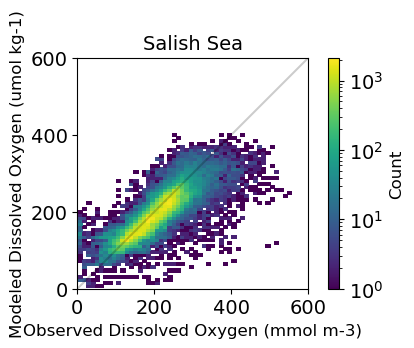

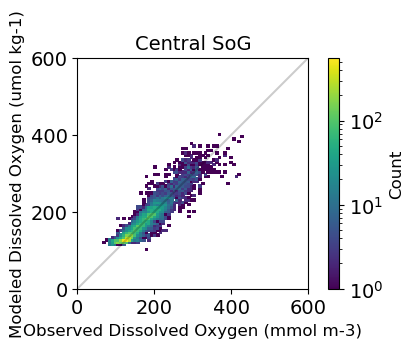

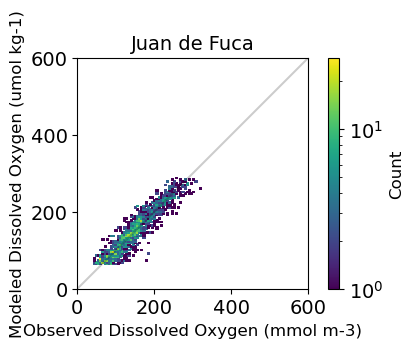

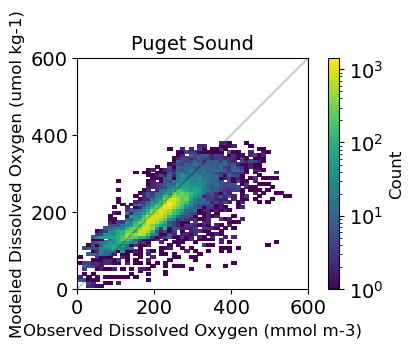

In [72]:


data=data
fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(data['DO (umol kg-1)']))&(~np.isnan(data['mod_dissolved_oxygen']))
counts, xedges, yedges, m1=ax.hist2d((data.loc[ii,['DO (umol kg-1)']].values.flatten()+.001),
                                      (data.loc[ii,['mod_dissolved_oxygen']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,600),(0,600),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_aspect(1)
ax.set_ylabel('Modeled Dissolved Oxygen (umol kg-1)',fontsize=12)
ax.set_xlabel('Observed Dissolved Oxygen (mmol m-3)',fontsize=12)
ax.set_title('Salish Sea')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(CentralSoG['DO (umol kg-1)']))&(~np.isnan(CentralSoG['mod_dissolved_oxygen']))
counts, xedges, yedges, m1=ax.hist2d((CentralSoG.loc[ii,['DO (umol kg-1)']].values.flatten()+.001),
                                      (CentralSoG.loc[ii,['mod_dissolved_oxygen']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,600),(0,600),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_aspect(1)
ax.set_ylabel('Modeled Dissolved Oxygen (umol kg-1)',fontsize=12)
ax.set_xlabel('Observed Dissolved Oxygen (mmol m-3)',fontsize=12)
ax.set_title('Central SoG')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(JdF['DO (umol kg-1)']))&(~np.isnan(JdF['mod_dissolved_oxygen']))
counts, xedges, yedges, m1=ax.hist2d((JdF.loc[ii,['DO (umol kg-1)']].values.flatten()+.001),
                                      (JdF.loc[ii,['mod_dissolved_oxygen']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,600),(0,600),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_aspect(1)
ax.set_ylabel('Modeled Dissolved Oxygen (umol kg-1)',fontsize=12)
ax.set_xlabel('Observed Dissolved Oxygen (mmol m-3)',fontsize=12)
ax.set_title('Juan de Fuca')

fig,ax=plt.subplots(1,1,figsize=(5,3))
ii=(~np.isnan(Puget['DO (umol kg-1)']))&(~np.isnan(Puget['mod_dissolved_oxygen']))
counts, xedges, yedges, m1=ax.hist2d((Puget.loc[ii,['DO (umol kg-1)']].values.flatten()+.001),
                                      (Puget.loc[ii,['mod_dissolved_oxygen']].values.flatten()+.001),bins=25*2,norm=LogNorm())

ax.plot((0,600),(0,600),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count',fontsize=12)
ax.set_xlim(0,600)
ax.set_ylim(0,600)
ax.set_aspect(1)
ax.set_ylabel('Modeled Dissolved Oxygen (umol kg-1)',fontsize=12)
ax.set_xlabel('Observed Dissolved Oxygen (mmol m-3)',fontsize=12)
ax.set_title('Puget Sound')

In [30]:
print(data['DO (umol kg-1)'].max())
print(data['mod_dissolved_oxygen'].max())

556.3028674975566
406.20489501953125


In [31]:
print(data['DO (umol kg-1)'].min())
print(data['mod_dissolved_oxygen'].min())

2.3898685324229305
0.0


In [32]:
print(data['DO (umol kg-1)'].mean())
print(data['mod_dissolved_oxygen'].mean())

198.01552378012724
189.90492877884594
